In [124]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
from scipy import stats
from nolds import lyap_r
from teaspoon.SP.network import ordinal_partition_graph
from teaspoon.SP.network_tools import remove_zeros
from teaspoon.SP.network_tools import make_network
from teaspoon.parameter_selection.MsPE import MsPE_tau
from LogisticMapDataset import LogisticMapDataset as LMD
from TimeSeriesPersistence import TimeSeriesPersistence as TSP
from TimeSeriesMergeTree import TimeSeriesMergeTree as TSMT
from TimeSeriesHVG import TimeSeriesHVG as TSHVG
from tsph import plot_time_series

# Topological Divergence Analysis for Chaotic Trajectory Classification

This chapter looks at time series generated by deterministic, but often unpredictable, systems, through the lens of topology: using persistence diagrams, merge trees, and horizontal visibility graphs.

## Structure

We introduce the basic principles for understanding chaos in a well-studied system, the Logistic map. We then review the classical measure of chaotic dynamics, the "Largest Lyapunov Exponent" (LLE) of the system, and show how it tracks the tendency of trajectories to diverge across the state space from infinitesimally close initial states. Next, we introduce some recent attempts to study chaotic systems using the tools of topological data analysis (TDA) and horizontal visibility graphs (HVG). The latter are already known to differentiate between deterministic and chaotic dynamics, and to exhibit certain properties when a system is chatoic. However HVGs are less studied as a means to approximate Lyapunov exponents of a system, while applications of TDA to chaos detection and quantification are still very young. This work contributes to both of these threads via the general framework we introduce.

The existing TDA and HVG techniques we review shortly will be taken as baselines for evaluating a new collection of topological divergence measures that we introduce. These measures, and the pipeline for building them, are the main contribution of this chapter. The measures, broadly speaking, capture differences in super and sublevel filtrations over sequences. This turns out to be useful for estimating Lyapunov exponents, a scalar measure of chaos, as we will show in a series of numerical experiments where we use the newly defined divergence measures as features in machine learning pipelines.

## Chaotic Trajectories

Broadly, a trajectory $x_n$ for $n=0,1,\ldots$ through the state space of a (discrete) dynamical system is considered to be chaotic when small perturbations to its inital condition $x_0$ result in large and unpredictable divergences in the subsequent evolution of the system.

### Lyapunov Exponents

More formally, given a discrete dynamical system described by the map $x_{n+1} = f(x_n)$, where $x_n$ is the state of the system at time $n$, the largest Lyapunov exponent $\lambda$ can be computed as follows. Consider two points in the state space at time $n$, $x_n$ and $x_n + \delta x_n$, which are infinitesimally close. Iterate both points one step forward in time using the map. The distance between the two points at time $n+1$, to a linear approximation, is then $\delta x_{n+1} = f'(x_n)\cdot \delta x_n$, where $f'(x_n)$ is the derivative of the map at $x_n$.

The largest Lyapunov exponent $\lambda$ for state $x_0$ is the limit

$$\lambda(x_0) = lim_{n\to\infty} \frac{1}{n}  \sum_{i=0}^{n-1} \log | f'(x_i) |.$$

[TODO: a bit of additional explanation on how this limit is motivated, given the linear approximation above.] This equation gives the average exponential rate of divergence of nearby trajectories in state space, but depends on $x_0$: not all initial states lie close to other states that will diverge from them, so we choose the LLE to be $\lambda = \max_{x_0} \lambda(x_0)$. Thus if $\lambda$ is positive, there exist infinitesimally close trajectories that will diverge from each other over time, resulting in the unpredictable behavior that characterises chaos.

### The Logistic Map

A canonical example of a chaotic system is the discrete time logistic map $x_{n+1} = f(x_n) := r x_n (1-x_n)$ for $r\in (0,4]$. As the value of $r$ is increased through its domain, the qualitative behaviour of the map for trajectories starting at almost all initial states $x_0\in (0,1)$ changes from predictable periodic behaviour, to unpredictable chaotic behaviour, and back again, an infinite number of times. As $r$ increases, stable periodic orbits *bifurcate* to orbits with larger numbers of cycles. Bifurcations happen on increasingly short scales. At certain critical values of $r$, the bifurcations converge to orbits that are no longer periodic, but chaotic, before stabilising again into periodic behaviour. The situation repeats as $r$ increases, moreover it repeats on increasingly short intervals of the domain of $r$ leading to fractal structure in the resulting *bifurcation diagram*: a plot of the state space values $x\in (0,1)$ visited by the system in its orbit for each $r\in (0,4]$.

### Bifurcation Diagram of Logistic Map

The bifurcation diagram for the Logistic map, generated by trajectories originating at $x_0 = 0.2$, is as follows, were we zoom in to the orbits for $r\in [3.5, 4.0]$. The dashed lines in the figure pick out, approximately, the locations of three of the infinite number of "islands of stability" having periodic orbits. In passing, note that the diagram shows larger values of the control parameter $r$ lead to trajectories that begin to fill the state space. This qualitative behaviour is known *topological transitivity* or *mixing* of the system, whereby it transitions over time from any state to any other state that is arbitrarily close to it [^1].

[^1]: Alligood, Kathleen T., Tim D. Sauer, and James A. Yorke. *Chaos: An Introduction to Dynamical Systems.* 1st Corrected ed. 1996. Corr. 2nd printing 2000 edition. New York, NY Heidelberg: Springer, 1996.

In [2]:
lmd = LMD(MIN_R=3.5, NUM_R=500, X0=0.2, TIME_SERIES_LENGTH=1000, RANDOM_R=False)

In [3]:
trajectories = np.array(lmd.trajectories)
r_values = np.array(lmd.r_values)

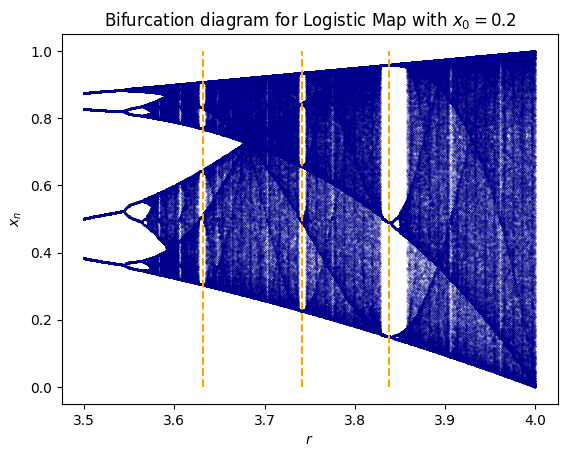

In [4]:
for i, r in enumerate(r_values):
    plt.scatter(r * np.ones_like(trajectories[i]), trajectories[i], s=0.01, c="darkblue")
plt.xlabel("$r$")
plt.ylabel("$x_n$")
plt.title("Bifurcation diagram for Logistic Map with $x_0=0.2$")
plt.plot([3.632, 3.632], [0, 1], linestyle="dashed", c="orange")
plt.plot([3.742, 3.742], [0, 1], linestyle="dashed", c="orange")
plt.plot([3.838, 3.838], [0, 1], linestyle="dashed", c="orange")
plt.show()

### Lyapunov Exponent for the Logistic Map

Since we know the Logistic Map function definition we can use its derivative $f'(x) = r - 2rx$ to approximate the Lyapunov exponent $\lambda$ directly:

$$\lambda(x_0) = lim_{n\to\infty} \frac{1}{n}  \sum_{i=0}^{n-1} \log | r - 2rx_i |.$$

This leads to the following plot of Lyapunov exponents, where we have computed the sum to $n=10000$.

In [59]:
logistic_data = LMD(MIN_R=3.4, TIME_SERIES_LENGTH=50)

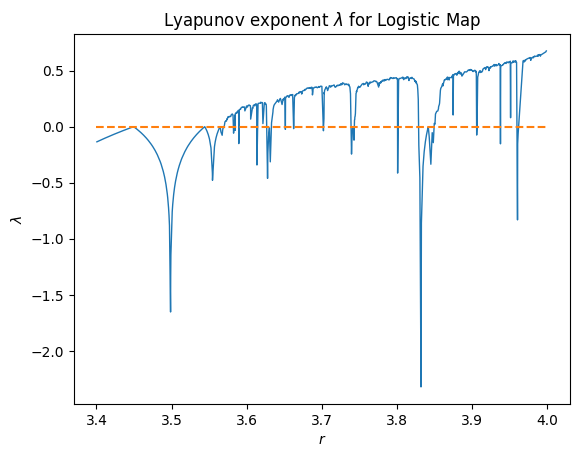

In [60]:
plt.plot(logistic_data.r_values, logistic_data.lyapunov_exponents, lw=1)
min_r, max_r = logistic_data.MIN_R, logistic_data.MAX_R
plt.plot([min_r, max_r], [0,0], linestyle="dashed")
plt.xlabel("$r$")
plt.ylabel("$\lambda$")
plt.title("Lyapunov exponent $\lambda$ for Logistic Map")
plt.show()

Notice there are values of $r$ for which $\lambda$ drops below $0$. These correspond to the "islands of stability" with periodic trajectories noted in the discussion of the bifurcation diagram. 

### Objective: chaos quantification as a data analysis problem

Of course, it is almost never the case in realistic applications that the evolution function $f(x_n)$ is known, so determining Lyapunov exponents os almost always an empirical, numerical, data analysis challenge.

One of our objectives below will be to find a proxy for the Lyapuov exponent, based on topological signatures of a time series, that can be estimated from the series directly without needing to know the dynamical model that generates the trajectory being analysed. 

## Divergences of Persistence Diagrams and their Vectorisations

Motivated by results in [^1] which show that a difference in the statistics of HVG degrees for a time series compared with the HVG of its negation signal chaos, by capturing differences in the geometry of peaks and pits in the underlying dynamic trajectory, we now introduce a number of *topological divergences* for time series. Our duality theorem for merge trees and HVGs implies that the topological divergences we define are each a continuous, sometimes stable, metric complement to the summaries of combinatorial features of HVGs studied in [^1].

Broadly, topological divergences for time series compare the superlevel and sublevel set filtrations over the series. Any given representation of a sublevel filtration (such as its persistence diagram, its merge tree, or a vectorisation of these) can be compared with the corresponding representation of the superlevel filtration, using an appropriate distance function. This gives us a map $Div:\mathbb{R}^n\to \mathbb{R}$ from a time series to a single real number, for any choice of filtration representation and optionally a vectorisation of this, called its topological divergence.

Below we show that, after an appropriate choice of representation and metric, the resulting topological divergence associated to a time series can be used as a feature in machine learning pipelines to detect and quantify the presence of chaos in dynamic systems.

[^1]: Hasson, Uri, Jacopo Iacovacci, Ben Davis, Ryan Flanagan, Enzo Tagliazucchi, Helmut Laufs, and Lucas Lacasa. *‘A Combinatorial Framework to Quantify Peak/Pit Asymmetries in Complex Dynamics’*. **Scientific Reports 8**, no. 1 (December 2018): 3557. https://doi.org/10.1038/s41598-018-21785-0.


### Measures of persistent homology divergence

Here we outline the definition of each of the divergences based on persistence diagrams. Subsequent sections look at extending these to divergences based on merge trees, decorated merge trees, and variations to the HVG based divergence appearing originally in [^1]. Ultimately we will evaluate each of these against a baseline of existing TDA approaches to detecting and quantifying chaos, and the combinatorial framework defined in [^1].

In [61]:
# list available persistence based vectorisations
tsph = [TSP(ts) for ts in logistic_data.trajectories]
print("Divergence names:", [k for k in tsph[0].divergences.keys()])

Divergence names: ['entropy', 'betti', 'silhouette', 'lifespan', 'stats', 'entropy_emd', 'betti_emd', 'silhouette_emd', 'lifespan_emd', 'stats_emd', 'bottleneck', 'wasserstein']


#### Bottleneck and Wasserstein divergences

These are simply the standard bottleneck or $p$-Wasserstein distance between the persistence diagrams of the superlevel and sublevel set 0-dimensional persistence diagrams of the time series. No vectorisation of the diagrams is required.

Suppose $\tau$ is a time series, $PL(\tau)$ is its piecewise linear interpolation, and $Dgm^-(PL(\tau))$ and $Dgm^+(PL(\tau))$ are respectively the sublevel and superlevel set persistence diagrams.

Recall that the bottleneck distance $d_b$ between two diagrams $D_1, D_2$ is the maximum distance in a perfect matching between the points in each diagram (a bijection between the multisets of points defining each diagram, including the points of the diagonal counted with infinite multiplicity) as follows.

$$d_b(D_1, D_2) := \inf_{\sigma:D_1 \to D_2} \max_{x\in D_1} \|x - \sigma(x)\|_\infty$$

The infimum is taken over all bijections $\sigma:D_1\to D_2$ between the diagrams.

The *bottleneck divergence* $Div(d_b, \tau)$ of a time series $\tau$ is then defined as follows.

$$Div(d_b, \tau) := d_b(Dgm^-(PL(\tau)), Dgm^+(PL(\tau)))$$

Similarly, recall that the $p$-Wasserstein distance $W_p$, for $p\geq 1$, between a pair of persistence diagrams $D_1, D_2$ takes into account *all* of the distances between pairs of points in a matching, not just the *maximum* such distance, as follows.

$$W_p(D_1, D_2) := \left( \inf_{\sigma:D_1 \to D_2} \sum_{x\in D_1} \|x - \sigma(x)\|^p \right)^{1/p}$$

The corresponding *Wasserstein divergence* $Div(W_p, \tau)$ of a time series $\tau$ is defined as follows.

$$Div(W_p, \tau) := W_p(Dgm^-(PL(\tau)), Dgm^+(PL(\tau)))$$

#### Persistence entropy divergence

We now consider vectorisation-based divergences.

Recall that the *lifetime* of a point $(b,d)$ occurring in a persistence diagram $D$ is the length $d-b$ of the corresponding bar in the barcode. Using lifetimes we can define the *entropy* of a persistence diagram. It is the expectation of the negative log (normalised) lifetimes in the diagram. Let $L_D := \sum_{(b,d)\in D} (d-b)$ be the sum of all lifetimes (counted with multiplicity), then the entropy $E_D$ of $D$ is defined as follows.

$$E_D := - \sum_{(b,d)\in D} \left( \frac{d-b}{L_D} \right) \log \left( \frac{d-b}{L_D} \right)$$

See [^1] and [^2] below for details of this definition and an application to medical data.

[^1]: H. Chintakunta, T. Gentimis, R. Gonzalez-Diaz, M. Jimenez, and H. Krim. An entropy-based persistence barcode. *Pattern Recognit., 48(2):391–401*, Feb. 2015.

[^2]: M. Rucco, F. Castiglione, E. Merelli, and M. Pettini. Characterisation of the idiotypic immune network through persistent entropy. In *Proceedings of ECCS 2014*, pages 117–128. Springer International Publishing, 2016.

A finer-grained measure of entropy over a diagram takes into account the *locations* of points appearing in the persistence diagram. Recall that a topological filtration is built as an increasing sequence of simplicial complexes for a continuously varying filtration parameter, often called the "height" $h\in \mathbb{R}$. Thus given any $h\in \mathbb{R}$ we can consider *only* those intervals $(b,d)$ in the barcode of the filtration, such that $b\leq h < d$, when computing the entropy. Intuitively, we consider the entropy of the lifetime of the bars in the barcode "alive" at each height $h$. This leads to the following piecewise constant function, defined in [^3] below and discussed in [^4], called the *life entropy curve*. The necessary adjustment to the diagram entropy $E_D$ above is to multiply the negative log lifetimes by the indicator function $\mathbb{1}_{b\leq h < d}(h):\mathbb{R}\to \{0,1\}$ for each point $(b,d)\in D$ in the diagram. An indicator function evaluates to $1$ when its condition holds and evaluates to $0$ when its condition does not hold.

$$E_D(h) := - \sum_{(b,d)\in D} \mathbb{1}_{b\leq h < d} \cdot \left( \frac{d-b}{L_D} \right) \log \left( \frac{d-b}{L_D} \right)$$

[^3]: N. Atienza, R. Gonzalez-Diaz, and M. Soriano-Trigueros. On the stability of persistent entropy and new summary functions for topological data analysis. *Pattern Recognition*, 107:107509, 2020.

[^4]: Y. Chung and A. Lawson. Persistence curves: A canonical framework for summarizing persistence diagrams. *Adv. Comput. Math.*, 48(1):6, 2022.

Two piecewise constant curves such as $E_D(h)$ can be compared using a variety of metrics. We will consider $L_p$ norms for $p=1,2$ and (somewhat confusingly) the Wasserstein distance for 1-d probability distributions. Since the latter is sometimes known as an *earth mover's distance* between distributions, to avoid confusion with the $p$-Wasserstein distance between persistence diagrams we have already been using, from this point on we will refer to the Wasserstein distance for 1-d probability distributions as $EMD$, and use the term "earth mover's distance".

We can now define the *entropy curve divergence* $Div(E_{Dgm}, \tau)$ of a time series $\tau$, based on the $L_p$ norm between functions, as follows.

$$Div(E_{Dgm}, \tau) := L_p\left( E_{Dgm^-(PL(\tau))}, E_{Dgm^+(PL(\tau))} \right)$$

The $EMD$-based divergence is defined analogously.

#### General notation for divergence measures

Anticipating the variety of topological representations of time series, the variety of vectorisations available for each of them, and the variety of metrics available for each vectorisation, and following the pattern of the definitions presented above, we adopt the following general notation.

A topological divergence is defined with respect to two choices: the choice of a representation for filtrations (here it will be the persistence diagram or a vectorisation of it, and in later sections we expand this to trees and HVGs) and the choice of a metric between such representations. 

Each topological divergence therfore has the following signature, where $Rep$ is a choice of representation, $Dist$ is a choice of distance/metric function suitable for the chosen representation, and $\tau$ is the time series.

$$Div(Rep, Dist, \tau)$$

In this notation, the topological divergences defined above are the following:

$$\text{Bottleneck: } Div(Dgm, d_b, \tau) \\ \text{Wasserstein: } Div(Dgm, W_p, \tau) \\ \text{Entropy curve $L_p$: } Div(E_{Dgm}, L_p, \tau) \\ \text{Entropy curve $EMD$: } Div(E_{Dgm}, EMD, \tau)$$

Implicit in this notation is the idea that the given representation, such as $Dgm$, will always be applied both to the sublevel and the superlevel filtration separately, giving back $Dgm^-$ and $Dgm^+$ in this example, before the distance function, such as $W_p$ is applied to the resulting pair of representations. Moreover, the filtration is always assumed to apply to the piecewise linear interpolation $PL(\tau)$ of the time series. A pipeline schematic for all topological divergences thus proceeds as:

$$\tau \mapsto PL(\tau) \mapsto \left( Rep^-(PL(\tau)), Rep^+(PL(\tau)) \right) \mapsto Dist \left( Rep^-(PL(\tau)), Rep^+(PL(\tau)) \right) \in \mathbb{R}$$

#### Further persistence-based divergences

Given a persistence diagram $D$ and a fitration height $h\in \mathbb{R}$, the *Betti number* $\beta_D(h)$ of the underlying filtered complex at height $h$ counts the bars alive in $D$ at $h$, $\beta_D(h) = | \{ (b,d) \in D : b \leq h < d \} |$. Equivalently, as a sum of indicator functions, the *Betti curve* of the diagram $D$ is defined as follows. 

$$\beta_D (h) := \sum_{(b,d)\in D} \mathbb{1}_{b\leq h <d}$$

As with the life entropy curve $E_D(h)$ above, the sum in this definition is over all persistence points counted with multiplicity.

This gives us two further topological divergences:

$$\text{Betti curve $L_p$: } Div(\beta_{Dgm}, L_p, \tau) \\ \text{Betti curve $EMD$: } Div(\beta_{Dgm}, EMD, \tau)$$

A slight variation on the Betti number adds barcode lifetimes to the sum above, to emphasise intervals of the height parameter over which homological features with greater persistence exist. The *lifespan curve* of a persistence diagram $D$, also defined in the reference [^3] above, is the following piecewise constant function $L_D(h):\mathbb{R}\to \mathbb{R}$.

$$L_D (h) := \sum_{(b,d)\in D} \mathbb{1}_{b\leq h <d} \cdot (d-b)$$

This gives the topological divergences:

$$\text{Lifespan curve $L_p$: } Div(L_{Dgm}, L_p, \tau) \\ \text{Lifespan curve $EMD$: } Div(L_{Dgm}, EMD, \tau)$$

Finally, at least for vectorisations of diagrams based on curves $\mathbb{R}\to \mathbb{R}$ like those above, is the *persistence silhouette* associated to a filtration. This is defined in the paper [^5] and has the advantage over Betti curves and lifetime curves of being stable with respect to perturbations to the input scalar function over which the filtration is built (the Betti and lifetime curves are not stable since scalar functions that have small bottleneck distance between their persistence diagrams can have arbitrarily large $L_p$ distances between their Betti and lifetime curves).

[^5]: F. Chazal, B. T. Fasy, F. Lecci, A. Rinaldo, and L. Wasserman. Stochastic convergence of persistence landscapes and silhouettes. In Proceedings of the Thirtieth Annual Symposium on Computational Geometry, SOCG’14, page 474–483, New York, NY, USA, 2014. Association for Computing Machinery.

First, for any bar $(b,d)$ in a persistence diagram, define the *tent function over $(b,d)$* to be the following function:

$$\Delta_{(b,d)} : \mathbb{R} \to \mathbb{R} ; h \mapsto \max(\min(h-b, d-h), 0).$$

The tent function is zero outside the interval $(b,d)\subseteq \mathbb{R}$, rises linearly from $(b,0)$ to $(\frac{d+b}{2}, \frac{d-b}{2})$, and then falls linearly to $(d,0)$, forming a "tent" over the interval $(b,d)$ in the domain.

A normalised sum of tent functions, over all bars appearing in a persistence diagram $D$, optionally weighing each bar using a weight function $w:D\to \mathbb{R}; (b,d)\mapsto w(b,d)$ defines the persistence silhouette representation:

$$ Sil_{D,w}(h) := \frac{\sum_{(b,d)\in D} w(b,d) \cdot \Delta_{(b,d)}(h)}{\sum_{(b,d)\in D} w(b,d)}.$$

In practice the weight function is usually chosen to be $w(d,b)=(d-b)^\alpha$ for some exponent $\alpha\geq 0$. Small values of $\alpha$ emphasise short bars in the diagram generating the silhouette function (usually considered to be noise artifacts) while large values of $\alpha$ emphasise the long bars in the diagram (usually considered to be the "topological signal").

The resulting topological divergences are parameterised by the weight function $w$. In terms of the divergence signature outlined above we have the following.

$$\text{Silhouette curve $L_p$: } Div(Sil_{Dgm, w}, L_p, \tau) \\ \text{Silhouette curve $EMD$: } Div(Sil_{Dgm, w}, EMD, \tau)$$

#### Divergence based on statistical point summaries of persistence

Basic statistical values, or *point summaries*, of persistence diagrams have been shown to be useful in characterising the classes that underly dynamic trajectories [^6]. Point summaries crop up in many papers, due to their simple definitions and nicer implementation properties than working with persistence diagrams directly, particularly in machine learning contexts [^7].

We use a comprehensive statistical summary, appearing as Definition 2.1 in [^8] and variants of which have been defined, used, and reviewed in [^9], [^10], [^11]. Given a persistence diagram $D$ we build a vector of point summary values for the following properties:

- The mean, standard deviation, median, interquartile range [TODO: define interquartile range], full range, the 10th, 25th, 75th, and 90th percentiles of the births $b$, deaths $d$, midpoints $\frac{b+d}{2}$, and lifespans $d-b$ for all points $(b,d)\in D$, counted with multiplicity.
- The total number of bars $B = |D| := \sum_{(b,d)\in D} 1$.
- The entropy $E_D$ of $D$ as defined above

This gives our final topological divergences based on persistence diagrams to be considered in this chapter:

$$\text{Persistence statistics $L_p$: } Div(Stat_{Dgm}, L_p, \tau) \\ \text{Persistence statistics $EMD$: } Div(Stat_{Dgm}, EMD, \tau).$$

[^6]: Myers, Audun, Elizabeth Munch, and Firas A. Khasawneh. ‘Persistent Homology of Complex Networks for Dynamic State Detection’. *Physical Review E* 100, no. 2 (21 August 2019): 022314. https://doi.org/10.1103/PhysRevE.100.022314.

[^7]: C. S. Pun, K. Xia, and S. X. Lee. Persistent-homology-based machine learning and its applications–a survey. *arXiv preprint* arXiv:1811.00252, 2018.

[^8]: Ali, Dashti, Aras Asaad, Maria-Jose Jimenez, Vidit Nanda, Eduardo Paluzo-Hidalgo, and Manuel Soriano-Trigueros. ‘A Survey of Vectorization Methods in Topological Data Analysis’. *arXiv*, 19 December 2022. https://doi.org/10.48550/arXiv.2212.09703.

[^9]: A. Asaad, D. Ali, T. Majeed, and R. Rashid. Persistent homology for breast tumor classification using mammogram scans. Mathematics, 10(21), 2022.

[^10]: Y. Chung and A. Lawson. Persistence curves: A canonical framework for summarizing persistence diagrams. Adv. Comput. Math., 48(1):6, 2022.

[^11]: C. S. Pun, K. Xia, and S. X. Lee. Persistent-homology-based machine learning and its applications–a survey. arXiv preprint arXiv:1811.00252, 2018.



## Initial analysis of persistence-based divergences

We will now compute the above topological divergences for logisic map trajectories for a range of values of the control parameter $r$. This section is intended merely to provide some intuition regarding the connections between the quantities we are interested in. A systematic numerical comparison appears in later sections.

In [62]:
def logistic_divergences(logistic_data : LMD) -> tuple[np.array, dict[np.array]]:
    time_series = logistic_data.trajectories
    r_values = logistic_data.r_values
    tsps = [TSP(ts) for ts in time_series]
    divergences = [tsp.divergences for tsp in tsps]
    return r_values, divergences

In [63]:
divergences = logistic_divergences(logistic_data)

#### Divergence plot as a function of $r$

We now visualise the entropy curve, silhouette curve, bottleneck, and Wasserstein divergences, bearing in mind the plot of the Lyapunov exponent $\lambda$ for the $r$ values of the Logistic map, shown above. Note that these divergences are not normalised, to the $y$-axes are different in each plot.

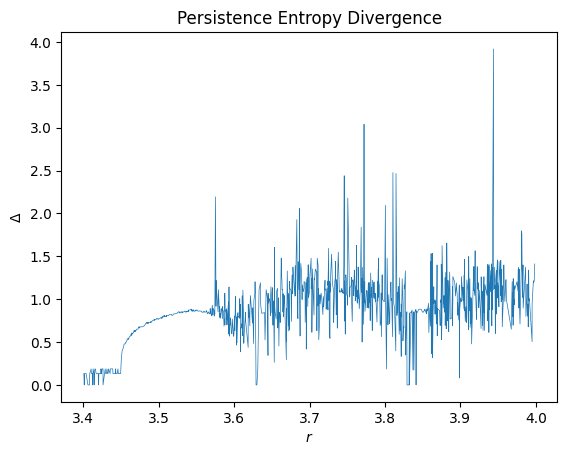

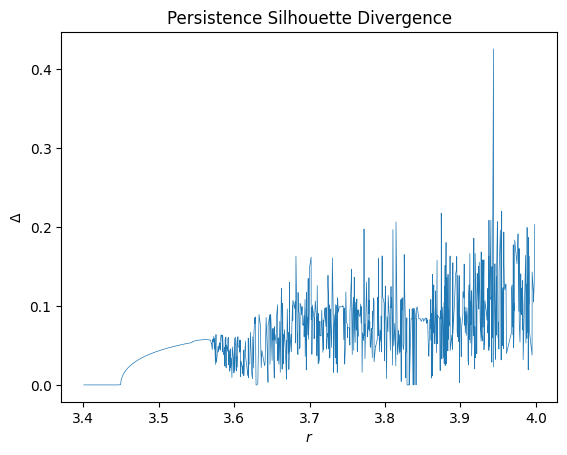

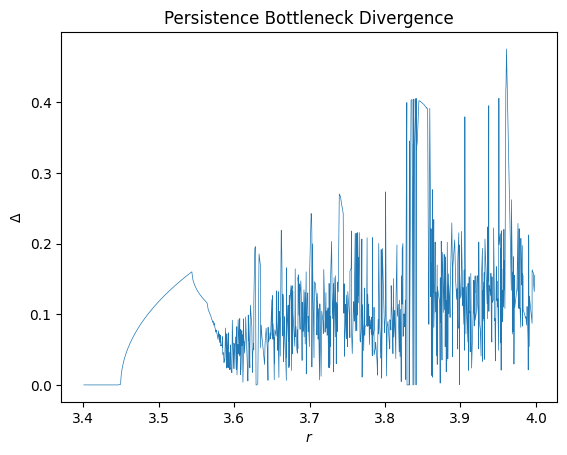

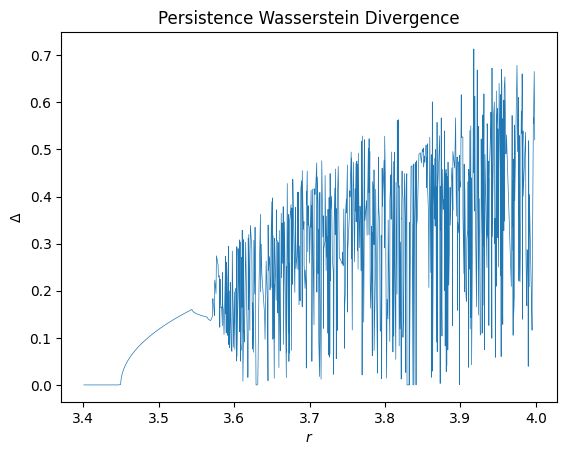

In [64]:
for div_name in ["entropy", "silhouette", "bottleneck", "wasserstein"]:
    plt.plot(divergences[0], [div[div_name] for div in divergences[1]], label=div_name, lw=0.5)
    plt.xlabel("$r$")
    plt.title(f"Persistence {div_name.title()} Divergence")
    plt.ylabel("$\Delta$")
    # plt.legend()
    plt.show()


Qualitatively, we can see echoes of the "islands of stability" in each of these plots, however it is not clear how well the divergences track the actual Lyapunov value as it varies. This is what we consider in the next subsection.

#### Comparison between Lyapunov exponents and topological divergences

The scatter plot of system Lyapunov exponent $\lambda$ and computed topological divergence gives a qualitative view of how well each divergence captures the extent to which $\lambda > 0$ is reflected in the divergence. Note that the divergences are not mutually normalised, so the $y$-axes are different in each of these plots.

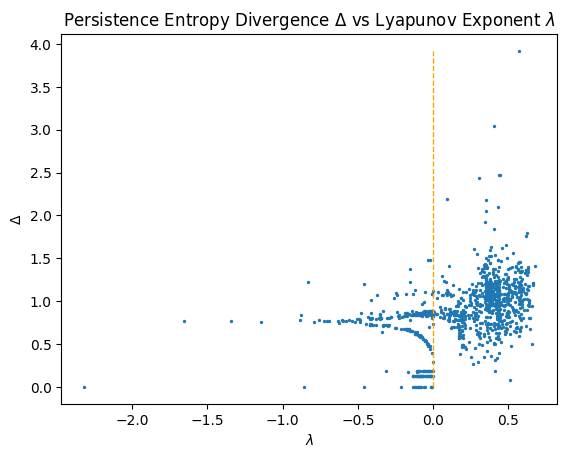

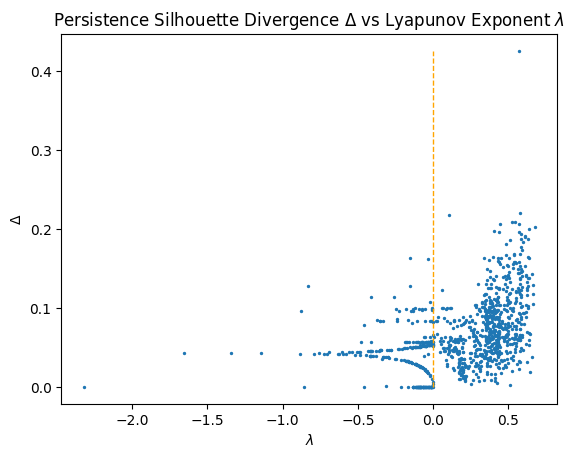

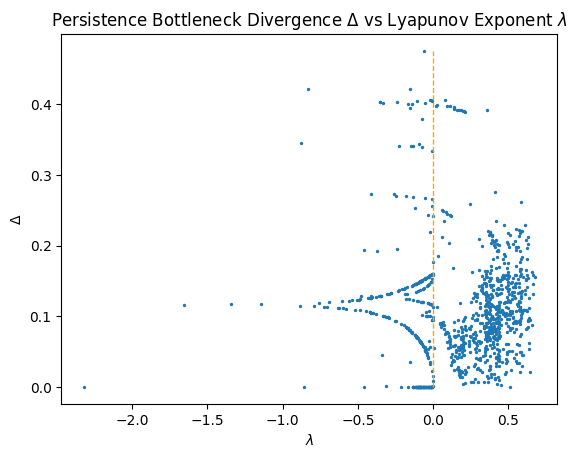

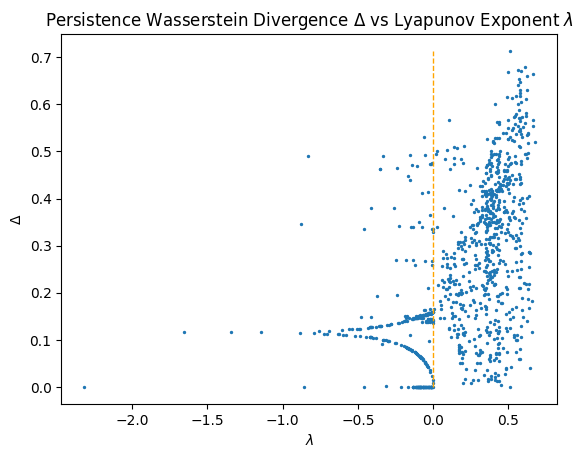

In [65]:
lyapunovs = logistic_data.lyapunov_exponents
for div_name in ["entropy", "silhouette", "bottleneck", "wasserstein"]:
    divs = [div[div_name] for div in divergences[1]]
    max_div = max(divs)
    plt.scatter(lyapunovs, divs, label=div_name, s=2)
    plt.plot([0,0],[0, max_div], c="orange", lw=1, linestyle="dashed")
    plt.title(f"Persistence {div_name.title()} Divergence $\Delta$ vs Lyapunov Exponent $\lambda$")
    plt.xlabel("$\lambda$")
    plt.ylabel("$\Delta$")
    # plt.legend()
    plt.show()

#### Comparison with non-topological baselines

The estimation of Lyapunov exponents has been implemented in a variety of numerical libraries. Here we use Python `nolds` library and its method `lyap_r` for estimating Lyapunov exponents using the algorithm of Rosenstein et. al. in [^12].

[^12]: M. T. Rosenstein, J. J. Collins, and C. J. De Luca, “A practical method for calculating largest Lyapunov exponents from small data sets,” *Physica D: Nonlinear Phenomena*, vol. 65, no. 1, pp. 117–134, 1993.

In [67]:
nolds_estimates = [lyap_r(ts, emb_dim=5) for ts in logistic_data.trajectories]

/Users/colin/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 12
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/colin/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 1
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/colin/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 12
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/colin/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 1
  warnings.warn(msg.format(lag), RuntimeWarning)
/Users/colin/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/nolds/measur

In [68]:
nolds_estimates_finite = np.array(nolds_estimates)
nolds_estimates_finite[nolds_estimates_finite == -np.inf] = -.075

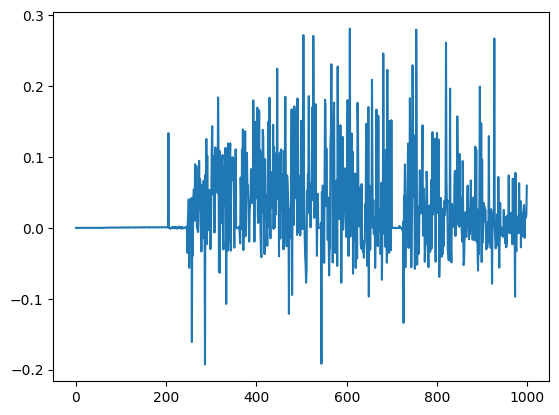

In [69]:
plt.plot(nolds_estimates_finite)
plt.show()

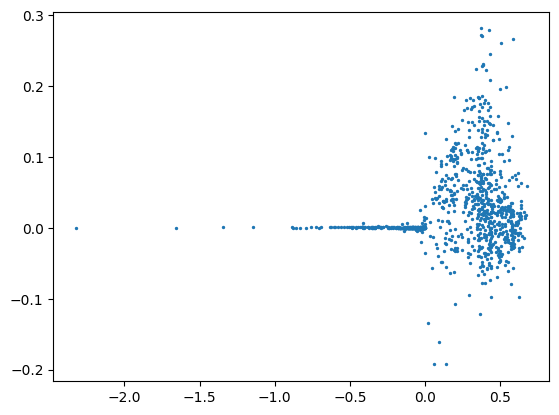

In [70]:
plt.scatter(lyapunovs, nolds_estimates_finite, s=2)

#### Comparison with TDA baseline

We use the Python `teaspoon` libarary to compute an ordinal partition graph of the time series and compute the persistent homology on this as a feature for chaos detection. This is the pipeline used in the paper [^13].

[^13]: Myers, Audun, Elizabeth Munch, and Firas A. Khasawneh. ‘Persistent Homology of Complex Networks for Dynamic State Detection’. *Physical Review E* 100, no. 2 (21 August 2019): 022314. https://doi.org/10.1103/PhysRevE.100.022314.


In [132]:
tau_estimates = [MsPE_tau(ts, delay_end=5) for ts in logistic_data.trajectories]

UnboundLocalError: local variable 'delay_peak' referenced before assignment

In [121]:
op_graphs = [ordinal_partition_graph(ts, n=3, tau=2) for ts in logistic_data.trajectories]

In [122]:
op_graphs_A = [remove_zeros(A) for A in op_graphs]

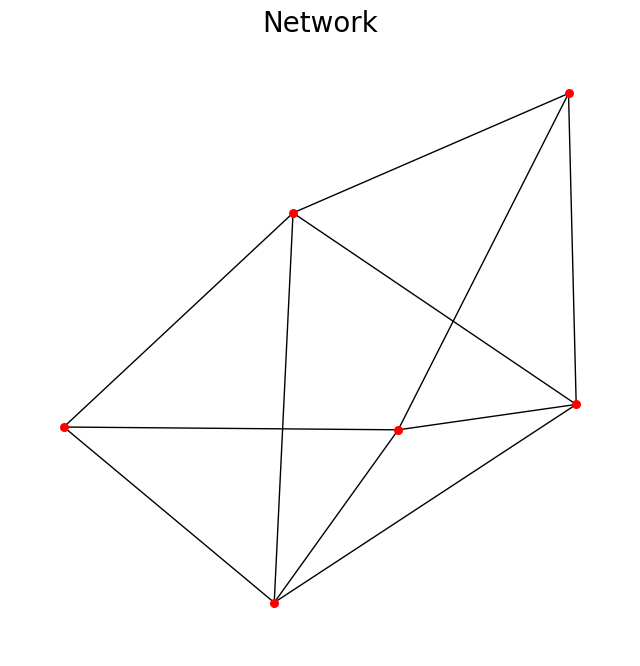

In [123]:
G, pos = make_network(op_graphs_A[-50])
plt.figure(figsize = (8,8))
plt.title('Network', size = 20)
nx.draw(G, pos, with_labels=False, font_weight='bold', node_color='red',
        width=1, font_size = 10, node_size = 30)
plt.show()